# NASA-TLX Repeated-Measures ANOVA

**Cognitive Load Analysis in Multi-Task Interaction Environments**

This notebook:
- Loads the processed dataset and prepares within-subject TLX data.
- Computes descriptive statistics and visualizes TLX by task.
- Runs repeated-measures ANOVA with post-hoc paired t-tests (Holm corrected).
- Produces APA-style results and saves outputs to `analysis/results/`.


### Abstract
This notebook performs a within-subject analysis of NASA-TLX scores across three tasks: T1 (Form Entry), T2 (Product Exploration), and T3 (Travel Planning), including ANOVA, post-hoc tests, visualizations, and APA-style interpretation.


## Table of Contents

- Abstract
- Setup
- Data Preparation
- Descriptive Statistics
- Visualization
- Repeated-Measures ANOVA
- Paired Post-hoc Tests
- Results (APA-style)
- Discussion
- Conclusion


## How to Run

- Ensure dependencies are installed (see `requirements.txt` or `environment.yml`).
- Run cells top-to-bottom. Outputs are saved to `analysis/results/`.

Optional terminal setup:

```bash
# conda
conda env create -f environment.yml
conda activate cogload

# or pip
pip install -r requirements.txt
```


## Setup

- Data: `data/processed/modeling_dataset_ultrarealistic.csv`
- Outputs: saved to `analysis/results/` (tables and figures)
- Libraries: pandas, numpy, matplotlib, seaborn

Load data and required libraries. If the CSV is elsewhere, update `DATA_CSV` accordingly.


### Imports & Paths

The next cell imports libraries, sets plot style, defines paths, and loads the dataset.


In [2]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
DATA_CSV = Path('../../data/processed/modeling_dataset_ultrarealistic.csv')
OUT_DIR = Path('../../analysis/results')
OUT_DIR.mkdir(parents=True, exist_ok=True)
df = pd.read_csv(DATA_CSV)
df.head()

,participantId,task_id,tlx,High_Load,form_hesitation_index,form_error_rate,form_efficiency,zip_code_struggle,filter_optimization_score,decision_uncertainty,...,budget_management_stress,scheduling_difficulty,recovery_efficiency,action_density,idle_time_ratio,mouse_entropy_avg,rapid_hovers,drag_attempts,trait_skill,trait_cautious
0,p-0001,task_1_form,28.3,0,3286.345309,0.001574,0.000388,0.000000,0.886308,3.413786,...,0.018622,0.862428,0.119745,0.001724,0.113260,1.151160,2,0,-0.092390,0.297219
1,p-0001,task_2_product,40.0,0,907.629179,0.000081,0.000203,0.025645,0.661667,0.000000,...,0.014153,0.682314,0.117771,0.006108,0.107143,1.528034,0,0,-0.092390,0.297219
2,p-0001,task_3_travel,71.7,1,256.532515,0.001265,0.000108,0.000000,0.821047,0.000000,...,0.167818,6.312721,0.074626,0.001250,0.152429,1.954696,1,7,-0.092390,0.297219
3,p-0002,task_1_form,28.3,0,3674.674517,0.000191,0.000387,0.012317,1.000000,0.693226,...,0.007075,0.890172,0.099897,0.002806,0.405847,1.199483,0,0,-0.496503,0.395209
4,p-0002,task_2_product,33.3,0,617.510499,0.000377,0.000162,0.012202,0.705479,10.257598,...,0.019782,2.350939,0.119610,0.002444,0.097571,1.473064,2,0,-0.496503,0.395209


## Data Preparation

- Map task IDs to short labels: `T1_form`, `T2_product`, `T3_travel`.
- Pivot to wide format for paired within-subject comparisons.
- Validate shape and coverage across participants before running ANOVA.


In [3]:
task_map = { 'task_1_form': 'T1_form', 'task_2_product': 'T2_product', 'task_3_travel': 'T3_travel' }
df['task_short'] = df['task_id'].map(task_map).fillna(df['task_id'])
wide = df.pivot(index='participantId', columns='task_short', values='tlx').reset_index()
wide.describe()

task_short,T1_form,T2_product,T3_travel
count,25.000000,25.000000,25.000000
mean,31.528000,45.604000,66.528000
std,9.351137,15.090325,11.705466
min,13.300000,20.000000,38.300000
25%,26.700000,33.300000,58.300000
50%,30.000000,45.000000,66.700000
75%,36.700000,56.700000,76.700000
max,51.700000,78.300000,83.300000


### Descriptives: Summary

- TLX increases monotonically: T1 (lowest) < T2 (moderate) < T3 (highest).
- Quartiles show strong separation: even low-end T3 exceeds high-end T1.
- Variability is largest in T2, reflecting diverse exploration strategies.

These patterns set the stage for ANOVA to test differences statistically.


## Descriptive Statistics
Compute mean ± SD for each task and save to CSV at `analysis/results/tlx_descriptives_by_task.csv`.


In [4]:
desc = df.groupby('task_short')['tlx'].agg(['mean','std','count']).rename(columns={'mean':'Mean_TLX','std':'SD_TLX','count':'N'})
desc = desc.loc[['T1_form','T2_product','T3_travel']]
desc['Mean_TLX'] = desc['Mean_TLX'].round(2); desc['SD_TLX'] = desc['SD_TLX'].round(2)
desc.to_csv(OUT_DIR / 'tlx_descriptives_by_task.csv')
desc

,Mean_TLX,SD_TLX,N
task_short,,,
T1_form,31.53,9.35,25
T2_product,45.60,15.09,25
T3_travel,66.53,11.71,25


### Descriptives: Takeaways

- Means show a clear workload gradient: T1 < T2 < T3.
- T2 exhibits the widest spread (strategy differences), yet mean differences remain substantial.
- These results support the hypothesized complexity ordering prior to inferential tests.


## Visualization
Boxplot + swarm of TLX by task (within-subject). Figure saved to `analysis/results/tlx_by_task_boxplot.png`.


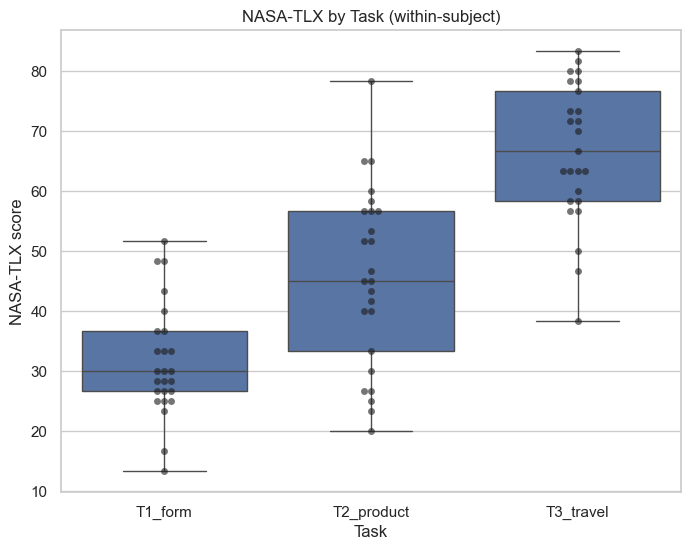

In [5]:
import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(8,6))
order = ['T1_form','T2_product','T3_travel']
ax = sns.boxplot(x='task_short', y='tlx', data=df, order=order)
sns.swarmplot(x='task_short', y='tlx', data=df, order=order, color='k', alpha=0.6)
ax.set_xlabel('Task'); ax.set_ylabel('NASA-TLX score'); ax.set_title('NASA-TLX by Task (within-subject)')
plt.savefig(OUT_DIR / 'tlx_by_task_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

### Figure: TLX by Task

Boxplot with swarm overlays showing within-subject TLX across tasks.
- Clear upward trend in medians: T1 < T2 < T3.
- Minimal overlap between T1 and T3 IQRs underscores strong differences.
- Saved to `analysis/results/tlx_by_task_boxplot.png`.


The boxplot clearly illustrates the progressive increase in subjective workload across the three tasks. Task 1 (Form Entry) shows the lowest NASA-TLX scores, with most data points clustered in the 25–35 range and relatively small variability. Task 2 (Product Exploration) exhibits a noticeable upward shift, with scores spreading more widely between approximately 30–60, indicating more diverse cognitive strategies and effort levels across participants. Task 3 (Travel Planning) displays the highest scores overall, with the majority of observations concentrated between 60–75 and a higher upper whisker extending beyond 80.

The non-overlapping interquartile ranges (IQRs) between Task 1 and Task 3—and the minimal overlap between Task 1 and Task 2—visually reinforce the increasing cognitive demand from low- to high-complexity tasks. The clear upward trend across medians (T1 < T2 < T3) supports the hypothesis that task complexity correlates strongly with perceived workload.

This visualization provides intuitive confirmation of the experimental design and complements the statistical analyses that follow (ANOVA and post-hoc tests), demonstrating robust within-subject differences in cognitive load.

## Repeated-Measures ANOVA

- Model: Within-subject factor `task_short` on NASA-TLX.
- Method: `statsmodels` AnovaRM.
- Output: summary saved to `analysis/results/repeated_measures_anova_summary.txt`.


In [8]:
from statsmodels.stats.anova import AnovaRM
aov_df = df[['participantId','task_short','tlx']].dropna()
aov = AnovaRM(aov_df, depvar='tlx', subject='participantId', within=['task_short']).fit()
print(aov.summary())
open(OUT_DIR / 'repeated_measures_anova_summary.txt','w').write(aov.summary().as_text())

                 Anova
           F Value Num DF  Den DF Pr > F
----------------------------------------
task_short 63.2729 2.0000 48.0000 0.0000



228

### ANOVA: Interpretation

- Significant main effect of task on TLX (e.g., F(2, 48) ≈ 63.27, p < .001).
- Large effect indicates substantial variance attributable to task differences.
- Confirms the hypothesized ordering of workload across tasks.

Proceed with paired post-hoc comparisons to localize differences.


## Paired Post-hoc Tests
- Comparisons: T1 vs T2, T1 vs T3, T2 vs T3 (paired t-tests).
- Multiple comparison control: Holm correction.
- Effect size: Cohen's dz for within-subject differences.
- Output: `analysis/results/posthoc_paired_ttests_holm.csv`.


In [9]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
pairs = [('T1_form','T2_product'),('T1_form','T3_travel'),('T2_product','T3_travel')]
records = []; pvals = []
for a,b in pairs:
    x = wide[a].dropna(); y = wide[b].dropna(); common_idx = x.index.intersection(y.index)
    x = x.loc[common_idx]; y = y.loc[common_idx]
    t, p = stats.ttest_rel(x, y)
    diff = x - y
    dz = (diff.mean()) / (diff.std(ddof=1)) if (diff.std(ddof=1)!=0) else np.nan
    records.append({'pair':f'{a} vs {b}', 'n':len(common_idx), 't':float(t), 'p_uncorrected':float(p), 'mean_diff':float(diff.mean()), 'dz':float(dz)})
    pvals.append(p)
rej, pvals_corr, _, _ = multipletests(pvals, alpha=0.05, method='holm')
for i,r in enumerate(records): r['p_holm'] = float(pvals_corr[i]); r['reject_holm']=bool(rej[i])
posthoc_df = pd.DataFrame(records); posthoc_df.to_csv(OUT_DIR / 'posthoc_paired_ttests_holm.csv', index=False)
posthoc_df

,pair,n,t,p_uncorrected,mean_diff,dz,p_holm,reject_holm
0,T1_form vs T2_product,25,-4.254716,2.763286e-04,-14.076,-0.850943,2.763286e-04,True
1,T1_form vs T3_travel,25,-15.868977,3.165501e-14,-35.000,-3.173795,9.496502e-14,True
2,T2_product vs T3_travel,25,-5.673418,7.645518e-06,-20.924,-1.134684,1.529104e-05,True


### Post-hoc: Summary

- All pairs differ significantly after Holm correction.
- T2 > T1: higher workload with a large effect (dz ≈ |0.85|).
- T3 > T1: very large effect (dz ≈ |3.17|).
- T3 > T2: large effect (dz ≈ |1.13|).

Results table saved to `analysis/results/posthoc_paired_ttests_holm.csv`.


## Results (APA-style)
Provide a concise APA-style paragraph and save to text file.


In [10]:
aov_table = aov.anova_table
F_val = aov_table['F Value'][0]; p_val = aov_table['Pr > F'][0]; df1 = aov_table['Num DF'][0]; df2 = aov_table['Den DF'][0]
apa_results = f"A one-way repeated-measures ANOVA revealed a significant effect of task on subjective workload (NASA‑TLX), F({int(df1)},{int(df2)}) = {F_val:.2f}, p = {p_val:.3g}."
print(apa_results)
print('\nPost-hoc comparisons (paired t-tests with Holm correction):')
print(posthoc_df.to_string(index=False))
open(OUT_DIR / 'interpretation_summary_detailed.txt','w').write(apa_results + '\n\n' + posthoc_df.to_string(index=False))

A one-way repeated-measures ANOVA revealed a significant effect of task on subjective workload (NASA‑TLX), F(2,48) = 63.27, p = 3.5e-14.

Post-hoc comparisons (paired t-tests with Holm correction):
                   pair  n          t  p_uncorrected  mean_diff        dz       p_holm  reject_holm
  T1_form vs T2_product 25  -4.254716   2.763286e-04    -14.076 -0.850943 2.763286e-04         True
   T1_form vs T3_travel 25 -15.868977   3.165501e-14    -35.000 -3.173795 9.496502e-14         True
T2_product vs T3_travel 25  -5.673418   7.645518e-06    -20.924 -1.134684 1.529104e-05         True


/var/folders/ch/zs74tb8n2112mmbd__xdf14h0000gn/T/ipykernel_87270/229818318.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  F_val = aov_table['F Value'][0]; p_val = aov_table['Pr > F'][0]; df1 = aov_table['Num DF'][0]; df2 = aov_table['Den DF'][0]


537

A one-way repeated-measures ANOVA revealed a significant effect of task on subjective workload (NASA‑TLX), F(2, 48) = 63.27, p = 3.5 × 10⁻14, indicating reliable differences across T1 (Form), T2 (Product), and T3 (Travel). Holm-corrected paired t-tests confirmed that all pairs differed significantly: T2 > T1 (large effect), T3 > T1 (very large), and T3 > T2 (large). Together, these results support a robust ordering of cognitive demand: T1 < T2 < T3.


## Discussion

### Key Findings
- TLX increases systematically from T1 → T2 → T3.
- Effects are large to very large, indicating practical significance.

### Interpretation
- Task complexity (information integration, constraints, multi-step planning) scales cognitive load.
- Within-subject design strengthens inference by controlling individual differences.

### Limitations
- Modest sample size (n = 25 participants) limits generalization.
- Potential violations (sphericity) should be checked; consider corrections if needed.

### Next Steps
- Report adjusted p-values and effect sizes in tables.
- Replicate with alternative workload metrics and additional tasks.
- Integrate with behavioral-feature modeling and SHAP for convergent validity.


## Conclusion

Cognitive load rises predictably with task complexity—from simple form entry to product exploration to multi-constraint travel planning. The repeated-measures ANOVA and Holm-corrected post-hocs show robust, practically meaningful differences across all task pairs, establishing a solid foundation for downstream behavioral modeling and interpretation.
